In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="A21XSJUvM7IVlgthXbJN")
project = rf.workspace("oral-cancel").project("oral-cancel-scanning-2.0")
version = project.version(4)
dataset = version.download("folder")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.8/89.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 69.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Oral-Cancel-Scanning-2.0-4 in folder:: 100%|██████████| 4620/4620 [00:00<00:00, 5675.65it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

base_dir = "/content/Oral-Cancel-Scanning-2.0-4"
train_dir = base_dir + "/train"
valid_dir = base_dir + "/valid"
test_dir  = base_dir + "/test"

img_size = (224, 224)
batch_size = 32
epochs = 10
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"  # "categorical" if more than 2 classes
)

# Validation dataset
val_generator = val_test_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)

# Test dataset
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)


Found 4008 images belonging to 2 classes.
Found 395 images belonging to 2 classes.
Found 206 images belonging to 2 classes.


In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Argument `alpha` is deprecated. Use `negative_slope` instead.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=1, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[lr_reduction, early_stop, checkpoint]
)


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.7929 - loss: 0.4636
Epoch 1: val_accuracy improved from -inf to 0.89620, saving model to best_model.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 127s 741ms/step - accuracy: 0.7933 - loss: 0.4628 - val_accuracy: 0.8962 - val_loss: 0.2661 - learning_rate: 0.0010
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8859 - loss: 0.2965
Epoch 2: val_accuracy improved from 0.89620 to 0.90633, saving model to best_model.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 56s 441ms/step - accuracy: 0.8859 - loss: 0.2964 - val_accuracy: 0.9063 - val_loss: 0.2299 - learning_rate: 0.0010
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9010 - loss: 0.2437
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: val_accuracy did not improve from 0.90633
126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 430ms/step - accuracy: 0.9009 - loss: 0.2437 - val_accuracy: 0.8987 - val_loss: 0.2569 - learning_rate: 0.0010


In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-50]:  # freeze first layers, fine-tune last 50 layers
    layer.trainable = False
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[lr_reduction, early_stop, checkpoint]
)

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9131 - loss: 0.2074
Epoch 1: val_accuracy did not improve from 0.92911
126/126 ━━━━━━━━━━━━━━━━━━━━ 131s 757ms/step - accuracy: 0.9131 - loss: 0.2073 - val_accuracy: 0.9266 - val_loss: 0.1875 - learning_rate: 1.0000e-04
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9463 - loss: 0.1362
Epoch 2: val_accuracy improved from 0.92911 to 0.93418, saving model to best_model.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 431ms/step - accuracy: 0.9462 - loss: 0.1363 - val_accuracy: 0.9342 - val_loss: 0.2024 - learning_rate: 1.0000e-04
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9487 - loss: 0.1270
Epoch 3: val_accuracy improved from 0.93418 to 0.93671, saving model to best_model.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 55s 437ms/step - accuracy: 0.9487 - loss: 0.1269 - val_accuracy: 0.9367 - val_loss: 0.1856 - learning_rate: 1.0000e-04
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accura

In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8902 - loss: 0.2878
Test Accuracy: 88.83%


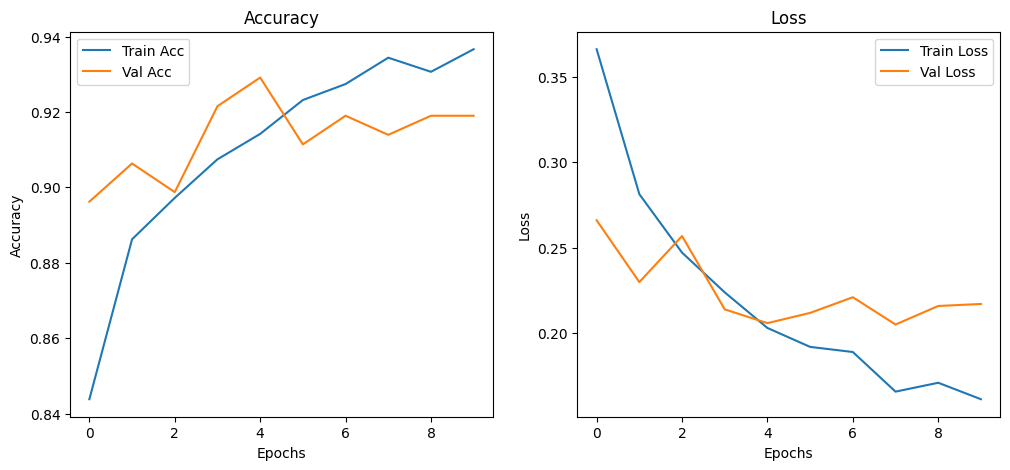

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step


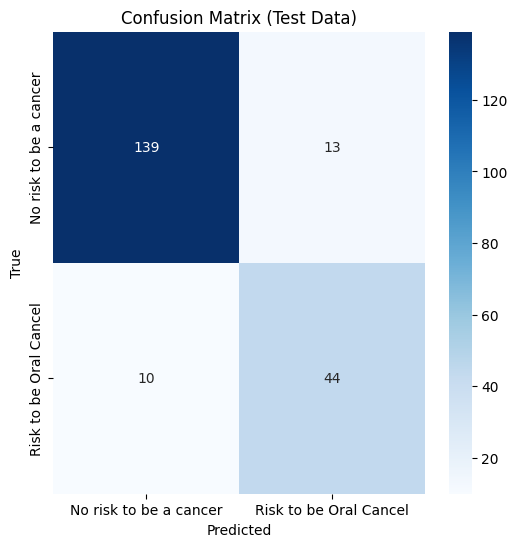


Classification Report:

                        precision    recall  f1-score   support

No risk to be a cancer       0.93      0.91      0.92       152
Risk to be Oral Cancel       0.77      0.81      0.79        54

              accuracy                           0.89       206
             macro avg       0.85      0.86      0.86       206
          weighted avg       0.89      0.89      0.89       206



In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.title("Confusion Matrix (Test Data)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


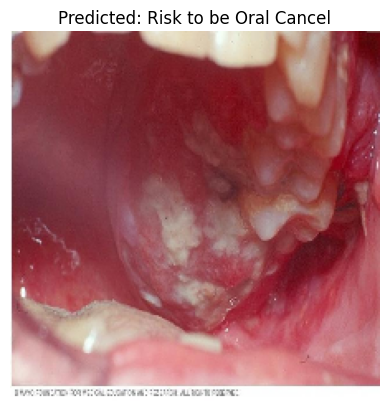

In [ ]:
import os
from tensorflow.keras.preprocessing import image

# Get class labels from the generator
class_labels = list(test_generator.class_indices.keys())

def predict_and_plot(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    predicted_class_index = (prediction > 0.5).astype("int32")[0][0]
    predicted_label = class_labels[predicted_class_index]

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

# Example usage: Replace 'path/to/your/image.jpg' with the actual path to your image
# You can upload an image to your Colab environment or use an image from your mounted Google Drive.
# For example, if you have an image named 'my_oral_scan.jpg' in your Google Drive's root folder,
# the path might be '/content/drive/MyDrive/my_oral_scan.jpg'
# If you uploaded an image directly to Colab, it might be in the '/content/' directory.
image_path_for_prediction = '/content/Oral-Cancel-Scanning-2.0-4/test/Risk to be Oral Cancel/dataset_mouth-cancer-symptoms-1_jpg.rf.88fddc25a5f3ecf4138f351388a97556.jpg' # Replace with your image path
predict_and_plot(image_path_for_prediction)

In [ ]:
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/best_model.keras'
model = load_model(model_path)